# Prophet 하이퍼파라미터

## #01. 준비작업

### [1] 패키지 참조

In [27]:
import warnings

warnings.filterwarnings(action="ignore")

from hossam.util import *
from hossam.plot import *
from hossam.timeserise import *

import seaborn as sb
from matplotlib import pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from pandas import concat

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/tsdata/air_passengers.xlsx", info=False)

## #02. 데이터 전처리

### [1] 데이터 프레임의 필드 이름 변경

In [3]:
df = origin.rename(columns={'Month': 'ds', 'Passengers': 'y'})
my_pretty_table(df.head())

+----+---------------------+-----+
|    | ds                  |   y |
|----+---------------------+-----|
|  0 | 1949-01-01 00:00:00 | 112 |
|  1 | 1949-02-01 00:00:00 | 118 |
|  2 | 1949-03-01 00:00:00 | 132 |
|  3 | 1949-04-01 00:00:00 | 129 |
|  4 | 1949-05-01 00:00:00 | 121 |
+----+---------------------+-----+


## #03. 하이퍼 파라미터

### [1] growth - 추정치의 상한선/하한선 설정하기

| 적용값 | 설명 |
|---|---|
| `linear` | 추정치 생성에 대한 제한이 없다. (기본값) |
| `logistic` | 추정치의 상한선, 하한선을 설정할 수 있다.<br/>데이터에 상한선을 의미하는 `cap` 필드와 `floor` 필드를 추가해야 한다. |

절대적인 기준은 아님

정해진 기준은 없고 모델을 돌리고 확인한 후에 설정하는 것을 추천

 여기서는 특정 값을 가정하지만 이는 일반적으로 시장 규모에 대한 데이터나 전문 지식을 사용하여 설정해야 한다.

#### (1) 상한선, 하한변 변수 정의

In [4]:
max_value = 500
min_value = 80

#### (2) 원본 데이터에 필드 추가

In [5]:
df2 = df.copy()
df2['cap'] = max_value
df2['floor'] = min_value

train, test = my_timeseries_split(df2)
train.shape, test.shape

((115, 4), (29, 4))

#### (2) 분석 결과 프레임에 상한선, 하한선 필드 추가

11:23:53 - cmdstanpy - INFO - Chain [1] start processing
11:23:53 - cmdstanpy - INFO - Chain [1] done processing


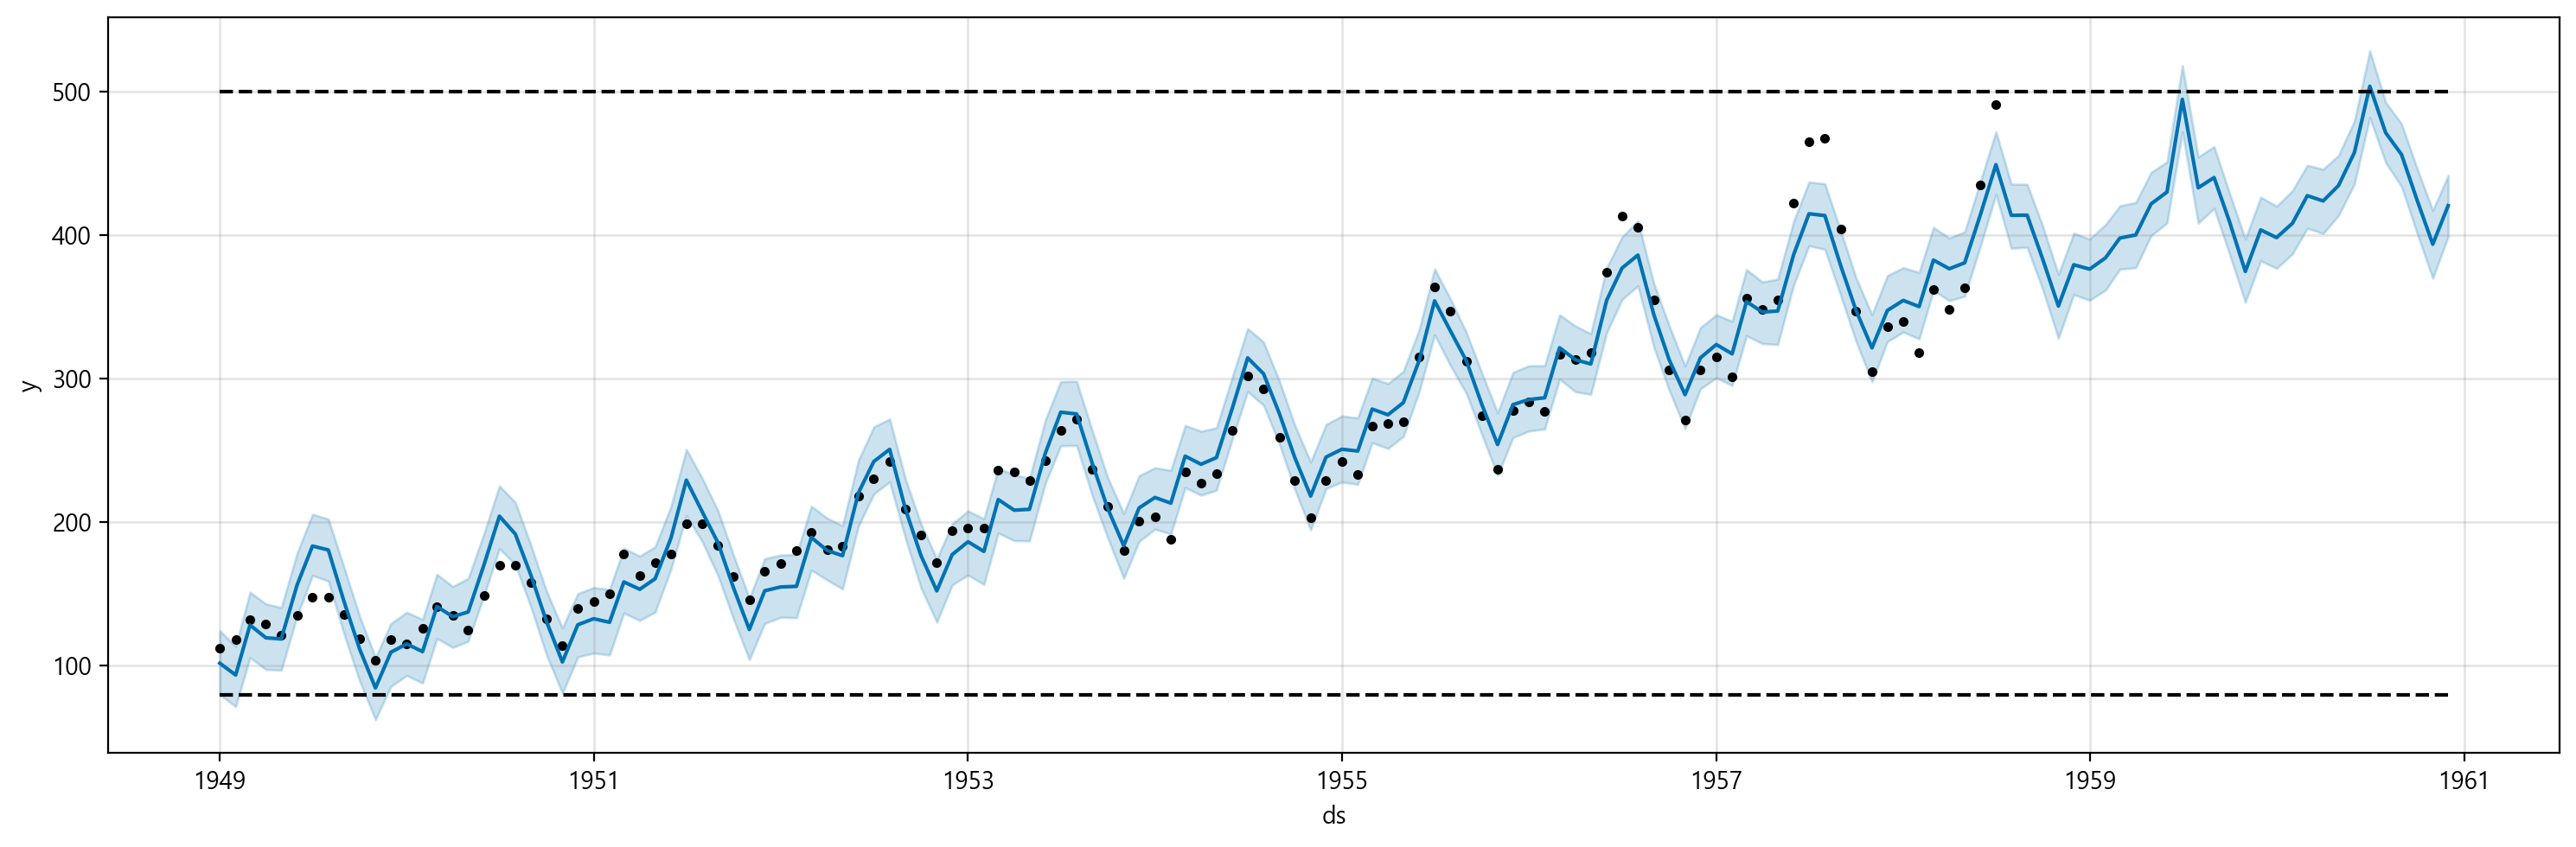

In [6]:
m = Prophet(growth="logistic")
m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
future['cap'] = max_value
future['floor'] = min_value

forecast = m.predict(future)

fig = m.plot(forecast, figsize=(15, 5))
fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()

### [2] Trend 관련 하이퍼 파라미터

| 파라미터 | 설명 |
|---|---|
| `changepoints` | 트렌드 변화시점을 명시한 리스트<br/> 수동 설정을 위한 파라미터로 잘 사용하지 않음 |
| **`changepoint_prior_scale`** | trend의 유연성 조절(기본값=0.05)<br/>추세에 덜 유연하기 반영하려면 `0.05`보다 작게 설정.<br/> 추세에 유연하게 반영하려면 `0.05`보다 크게 설정 |
| `n_changepoints` | chagepoint의 개수<br/>일반적인 시계열의 추세 변화를 파악하기 위해서 충분한 수로 설정해야 함.<br/>변경점의 수를 늘리거나 줄이는 것보다 추세 변화에서 유연성을 변경하는 것이 더 효과적일 수 있음 |
| `changepoint_range` | chagepoint 설정 가능 범위 (기본적으로 데이터 중 `80%` 범위 내에서 changepoint를 설정한다)<br/>조절 범위 `0.8 ~ 0.95` |

만약 트렌드가 바뀌는 시점(서비스 확대 배포 또는 프로모션 등으로 인한 변화 시점)을 알고 있다면, changepoints 파라미터를 추가할 수 있고, changepoints 수 또한 n_changepoints 로 지정할 수 있다.

물론, 이 두 파라미터를 설정해주지 않아도 모델이 자동으로 감지하기 때문에 이 두 값은 잘 사용하지 않는다.

#### (1) 기본 상태로 Trend 확인

11:34:25 - cmdstanpy - INFO - Chain [1] start processing
11:34:25 - cmdstanpy - INFO - Chain [1] done processing


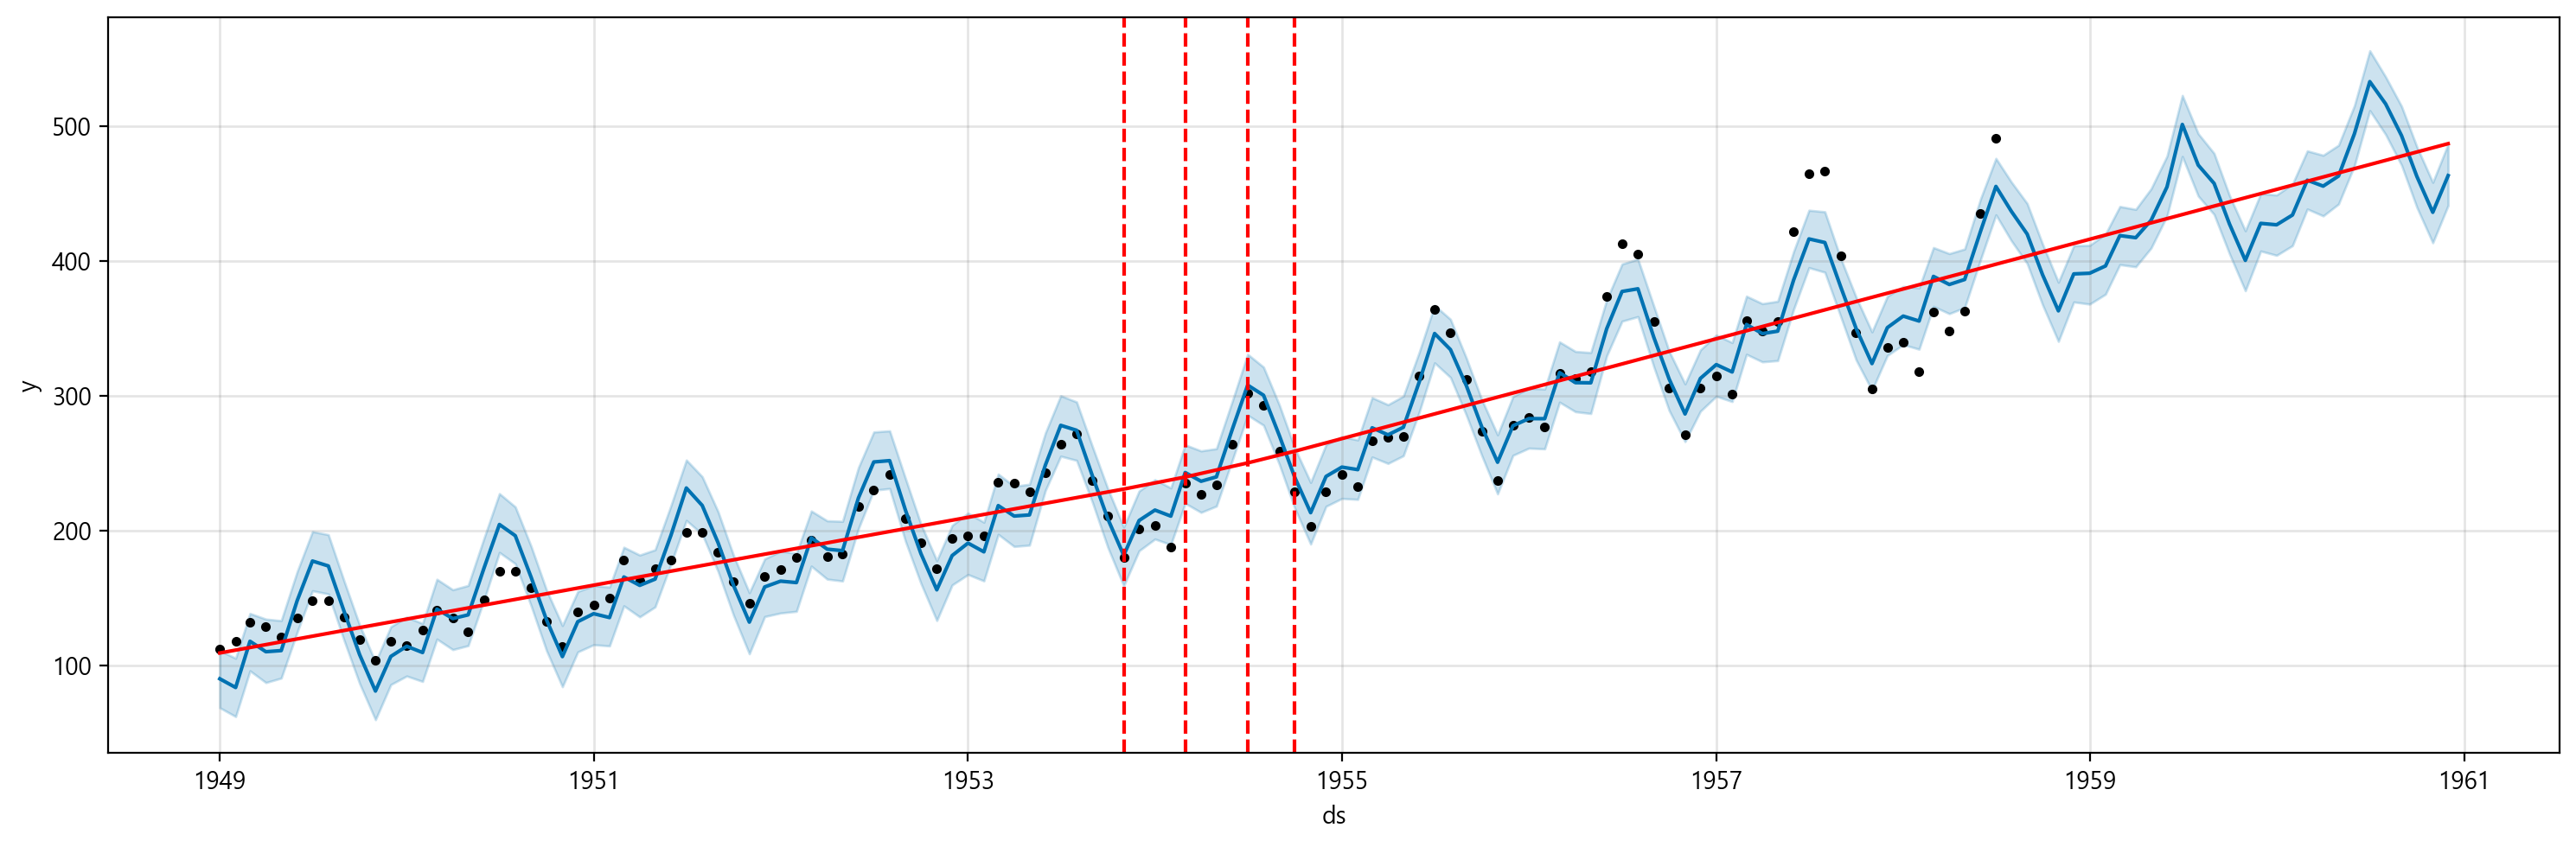

In [14]:
train, test = my_timeseries_split(df.copy())

m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(15,5))
add_changepoints_to_plot(fig.gca(), m, forecast)

fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()

#### (2) 트렌드 감지의 유연성 낮추기

트렌드 변경 시점을 넓게 설정한다.

11:23:54 - cmdstanpy - INFO - Chain [1] start processing
11:23:54 - cmdstanpy - INFO - Chain [1] done processing


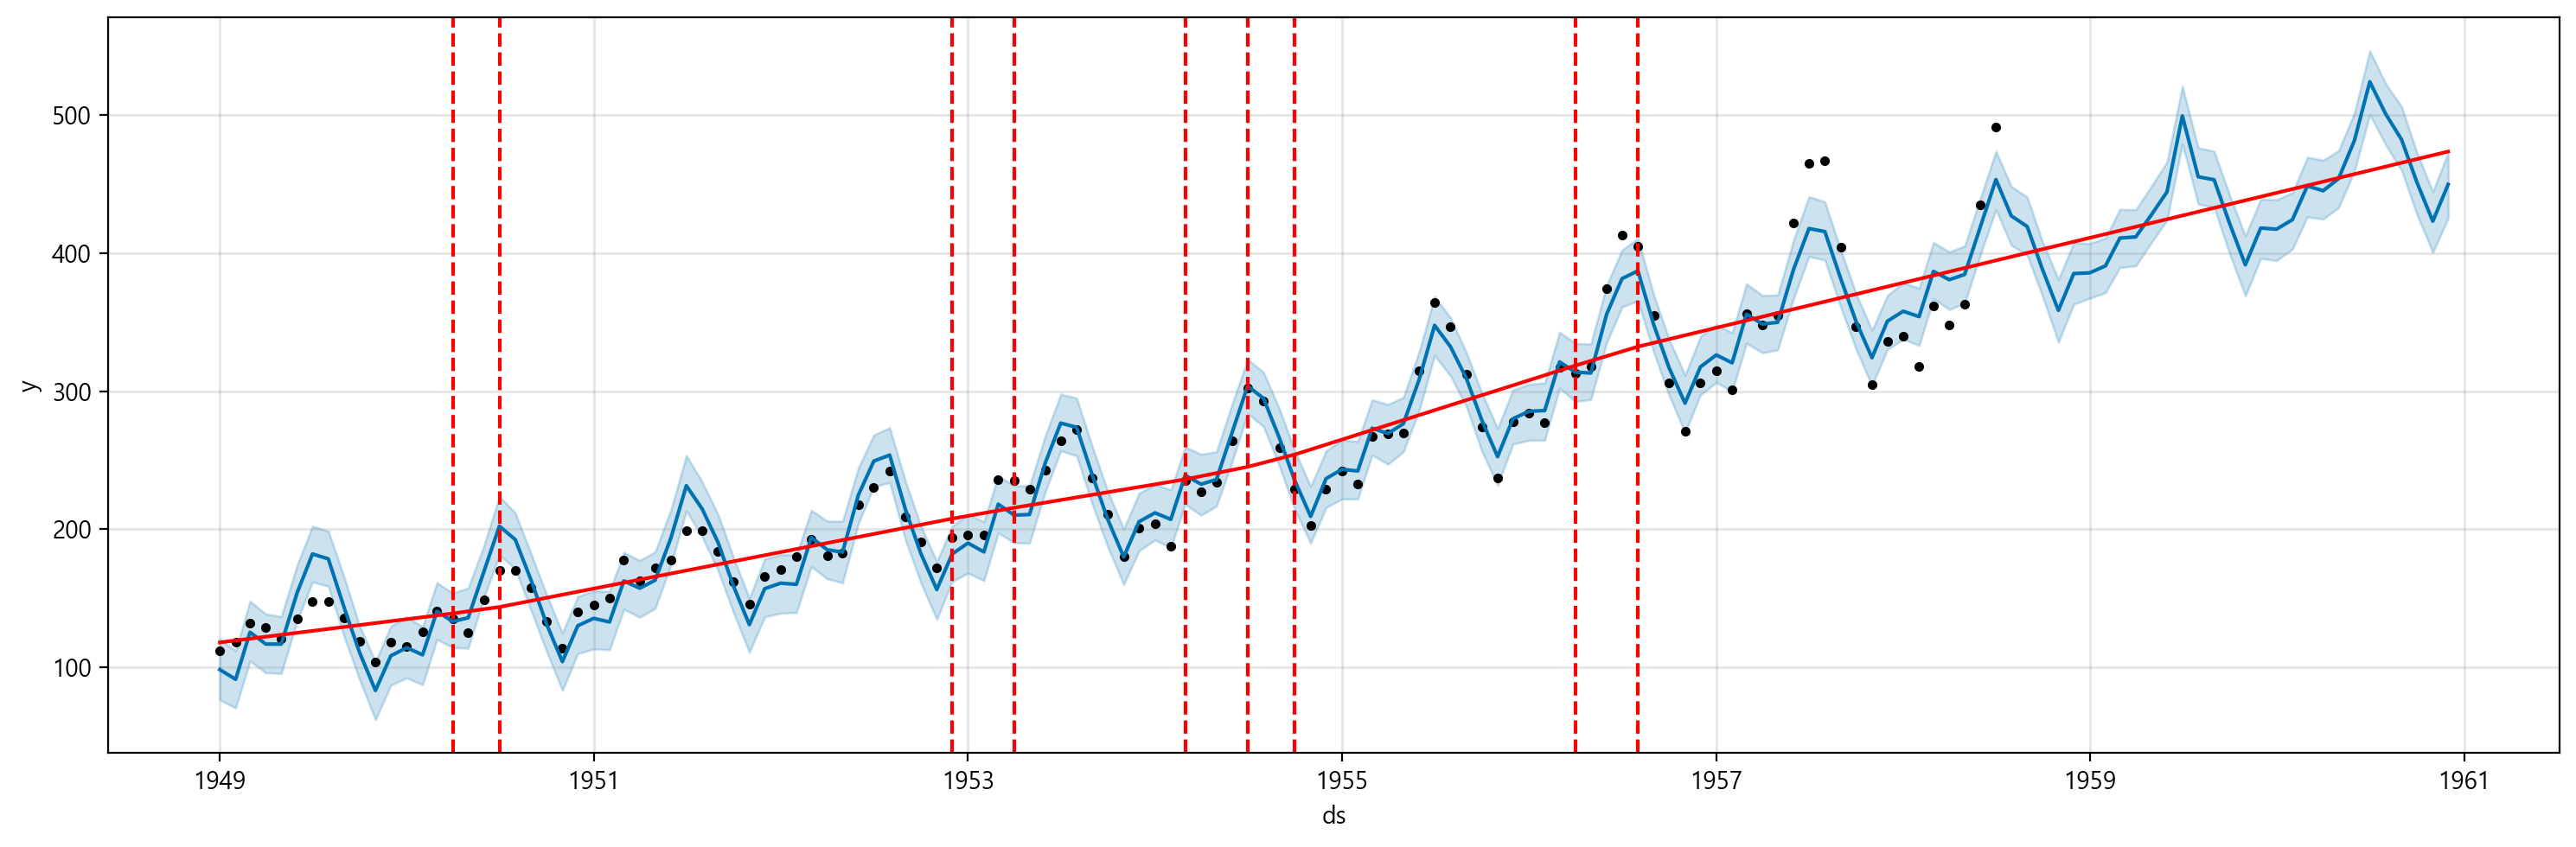

In [8]:
m = Prophet(changepoint_prior_scale=0.2)
m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(15, 5))
add_changepoints_to_plot(fig.gca(), m, forecast)

fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()

> changepoint_prior_scale 값을 0.3으로 변경한 후 트렌드를 더 유연하게 감지하는 것을 확인할 수 있다. 이 값을 너무 높거나 낮다면 overfitting의 위험이 있으니 주의해야 한다.

#### (3) 트렌드 감지의 유연성 높이기

트렌드 변경 시점을 더 촘촘하게 찾아낸다.

11:23:55 - cmdstanpy - INFO - Chain [1] start processing
11:23:55 - cmdstanpy - INFO - Chain [1] done processing


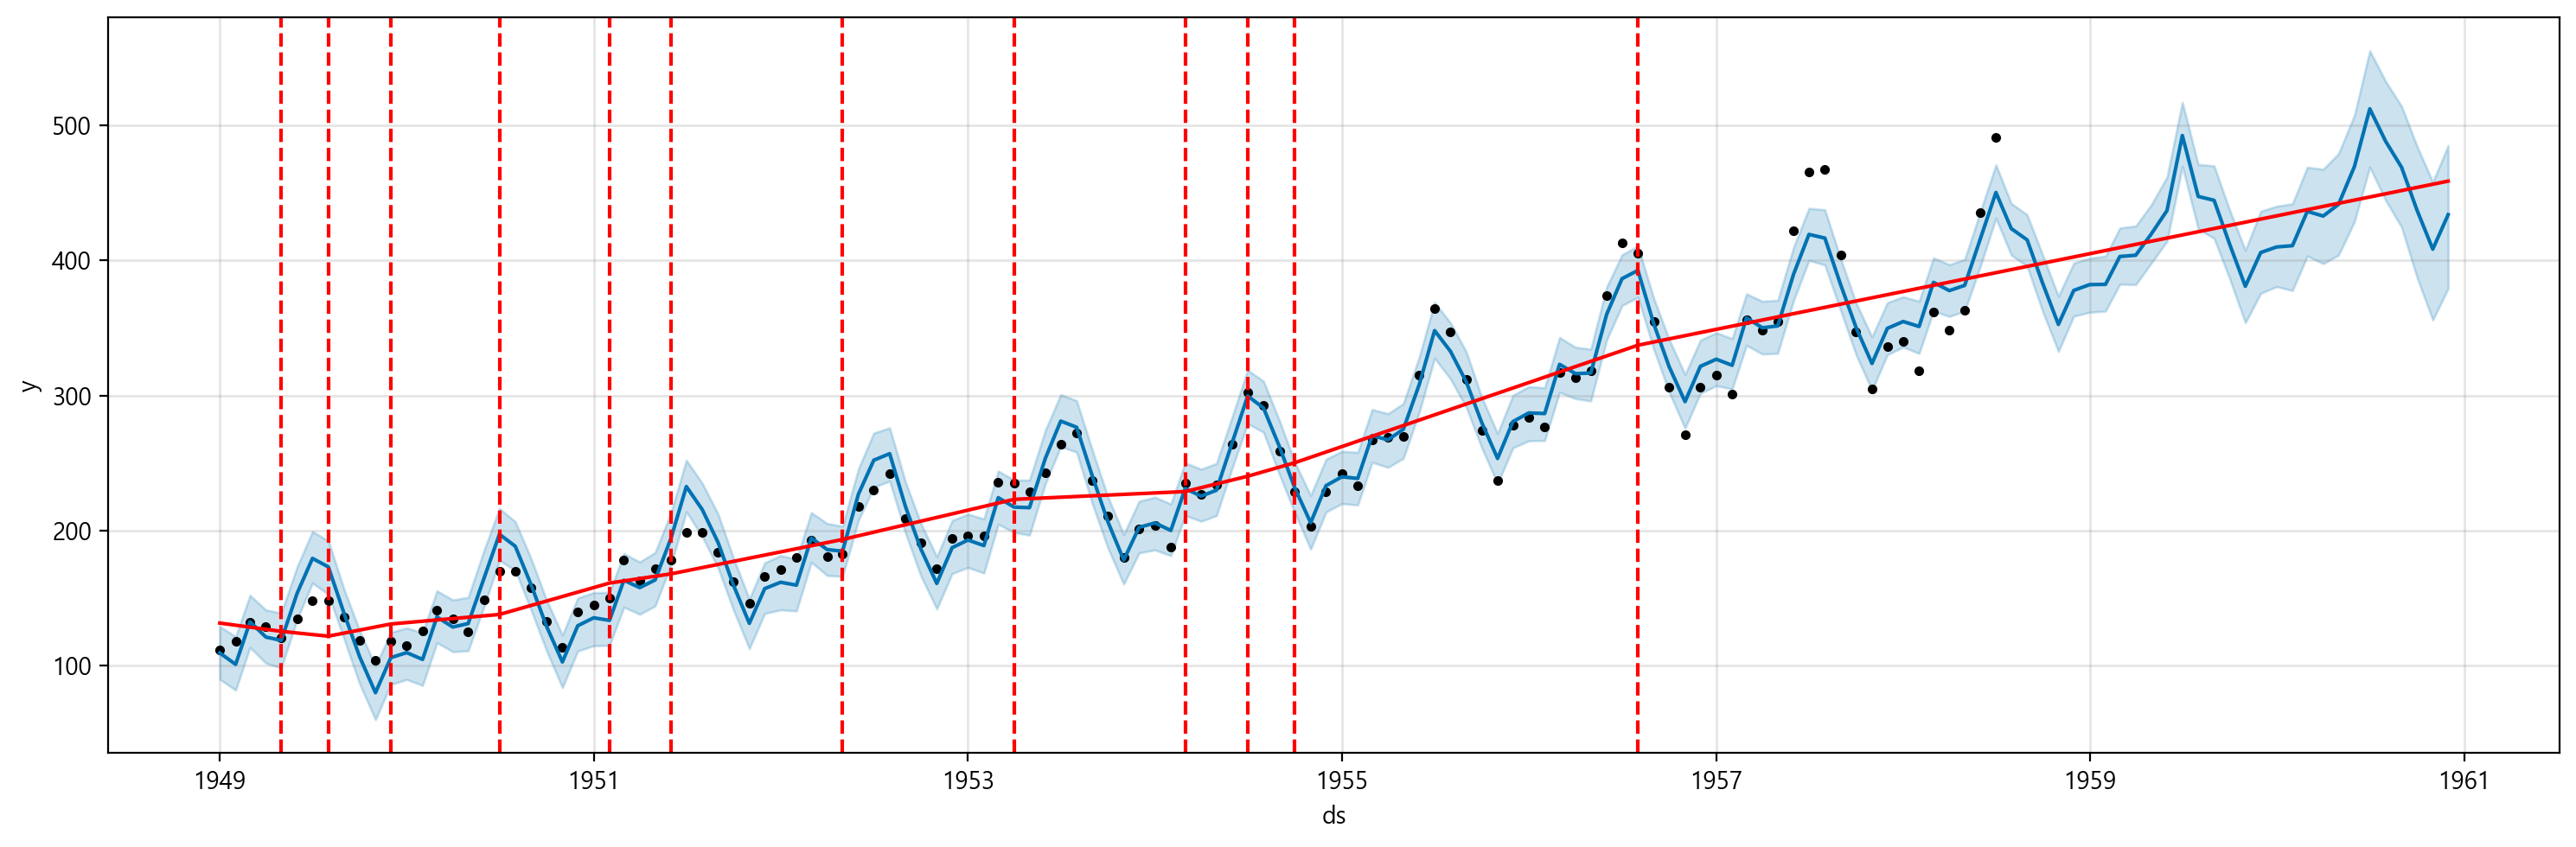

In [9]:
m = Prophet(changepoint_prior_scale=0.9)
m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot(forecast, figsize=(15, 5))
add_changepoints_to_plot(fig.gca(), m, forecast)

fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()

### [3] 모델의 계절성(Seasonality) 조절

| 파라미터 | 설명 |
|---|---|
| `yearly_seasonality` | 연 계절성(bool, 숫자, 기본값=auto) |
| `weekly_seasonality` | 주 계절성(bool, 숫자, 기본값=auto), 한 주 안에서의 요일 단위 |
| `daily_seasonality` | 일 계절성(bool, 숫자, 기본값=auto), 하루 안에서의 시간단위 |
| `seasonality_prior_scale` | 계절성 반영 강도. 합리적인 조정 범위는 [`0.01, 0.1 , 1, 10`] 사이  |
| `seasonality_mode` | `additive`(기본값, 진폭이 일정) or `multiplicative` (진폭이 점점 증가하거나 감소할 때 설정) |

 푸리에급수 계절성 패턴을 추정함

#### (1) 기본적으로 추정된 계절성 확인

11:23:55 - cmdstanpy - INFO - Chain [1] start processing
11:23:55 - cmdstanpy - INFO - Chain [1] done processing


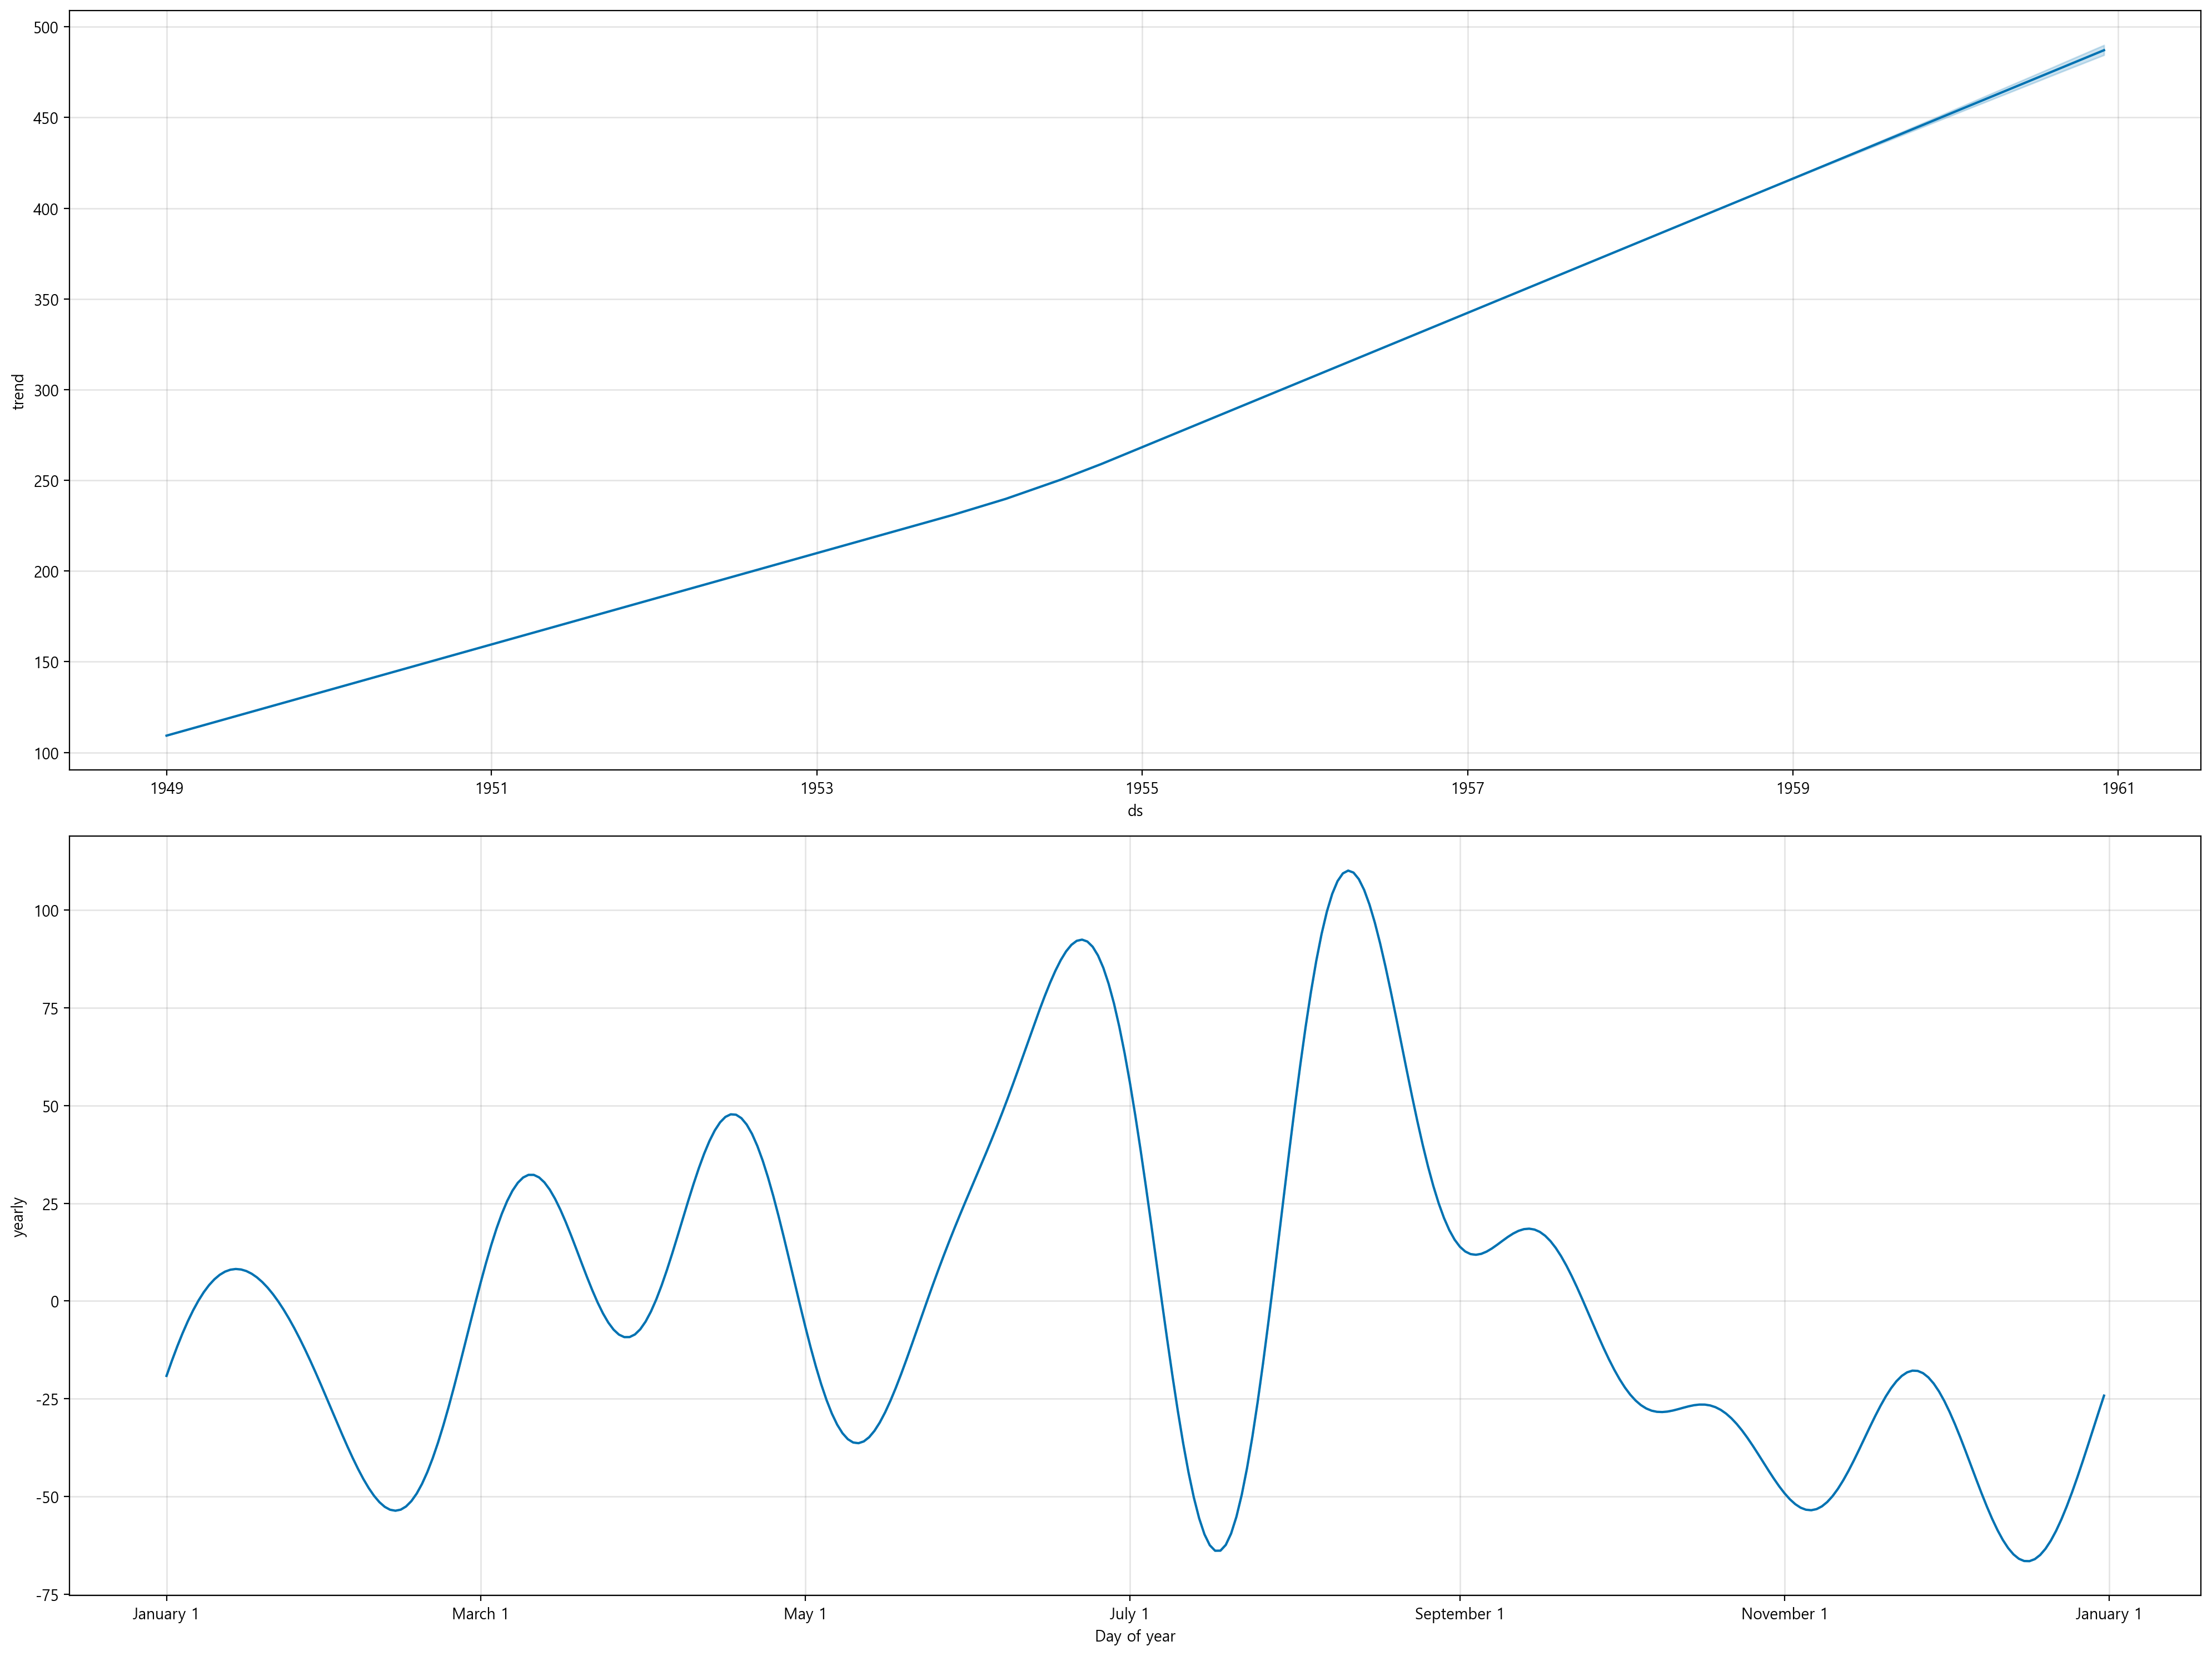

In [10]:
m = Prophet()
m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize=(20, 15))
fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()

> 자동으로 추론된 계절성은 년단위만 존재함

#### (2) 직접 계절성 설정

년단위 제거, 주단위, 일단위를 설정

11:23:56 - cmdstanpy - INFO - Chain [1] start processing
11:23:56 - cmdstanpy - INFO - Chain [1] done processing


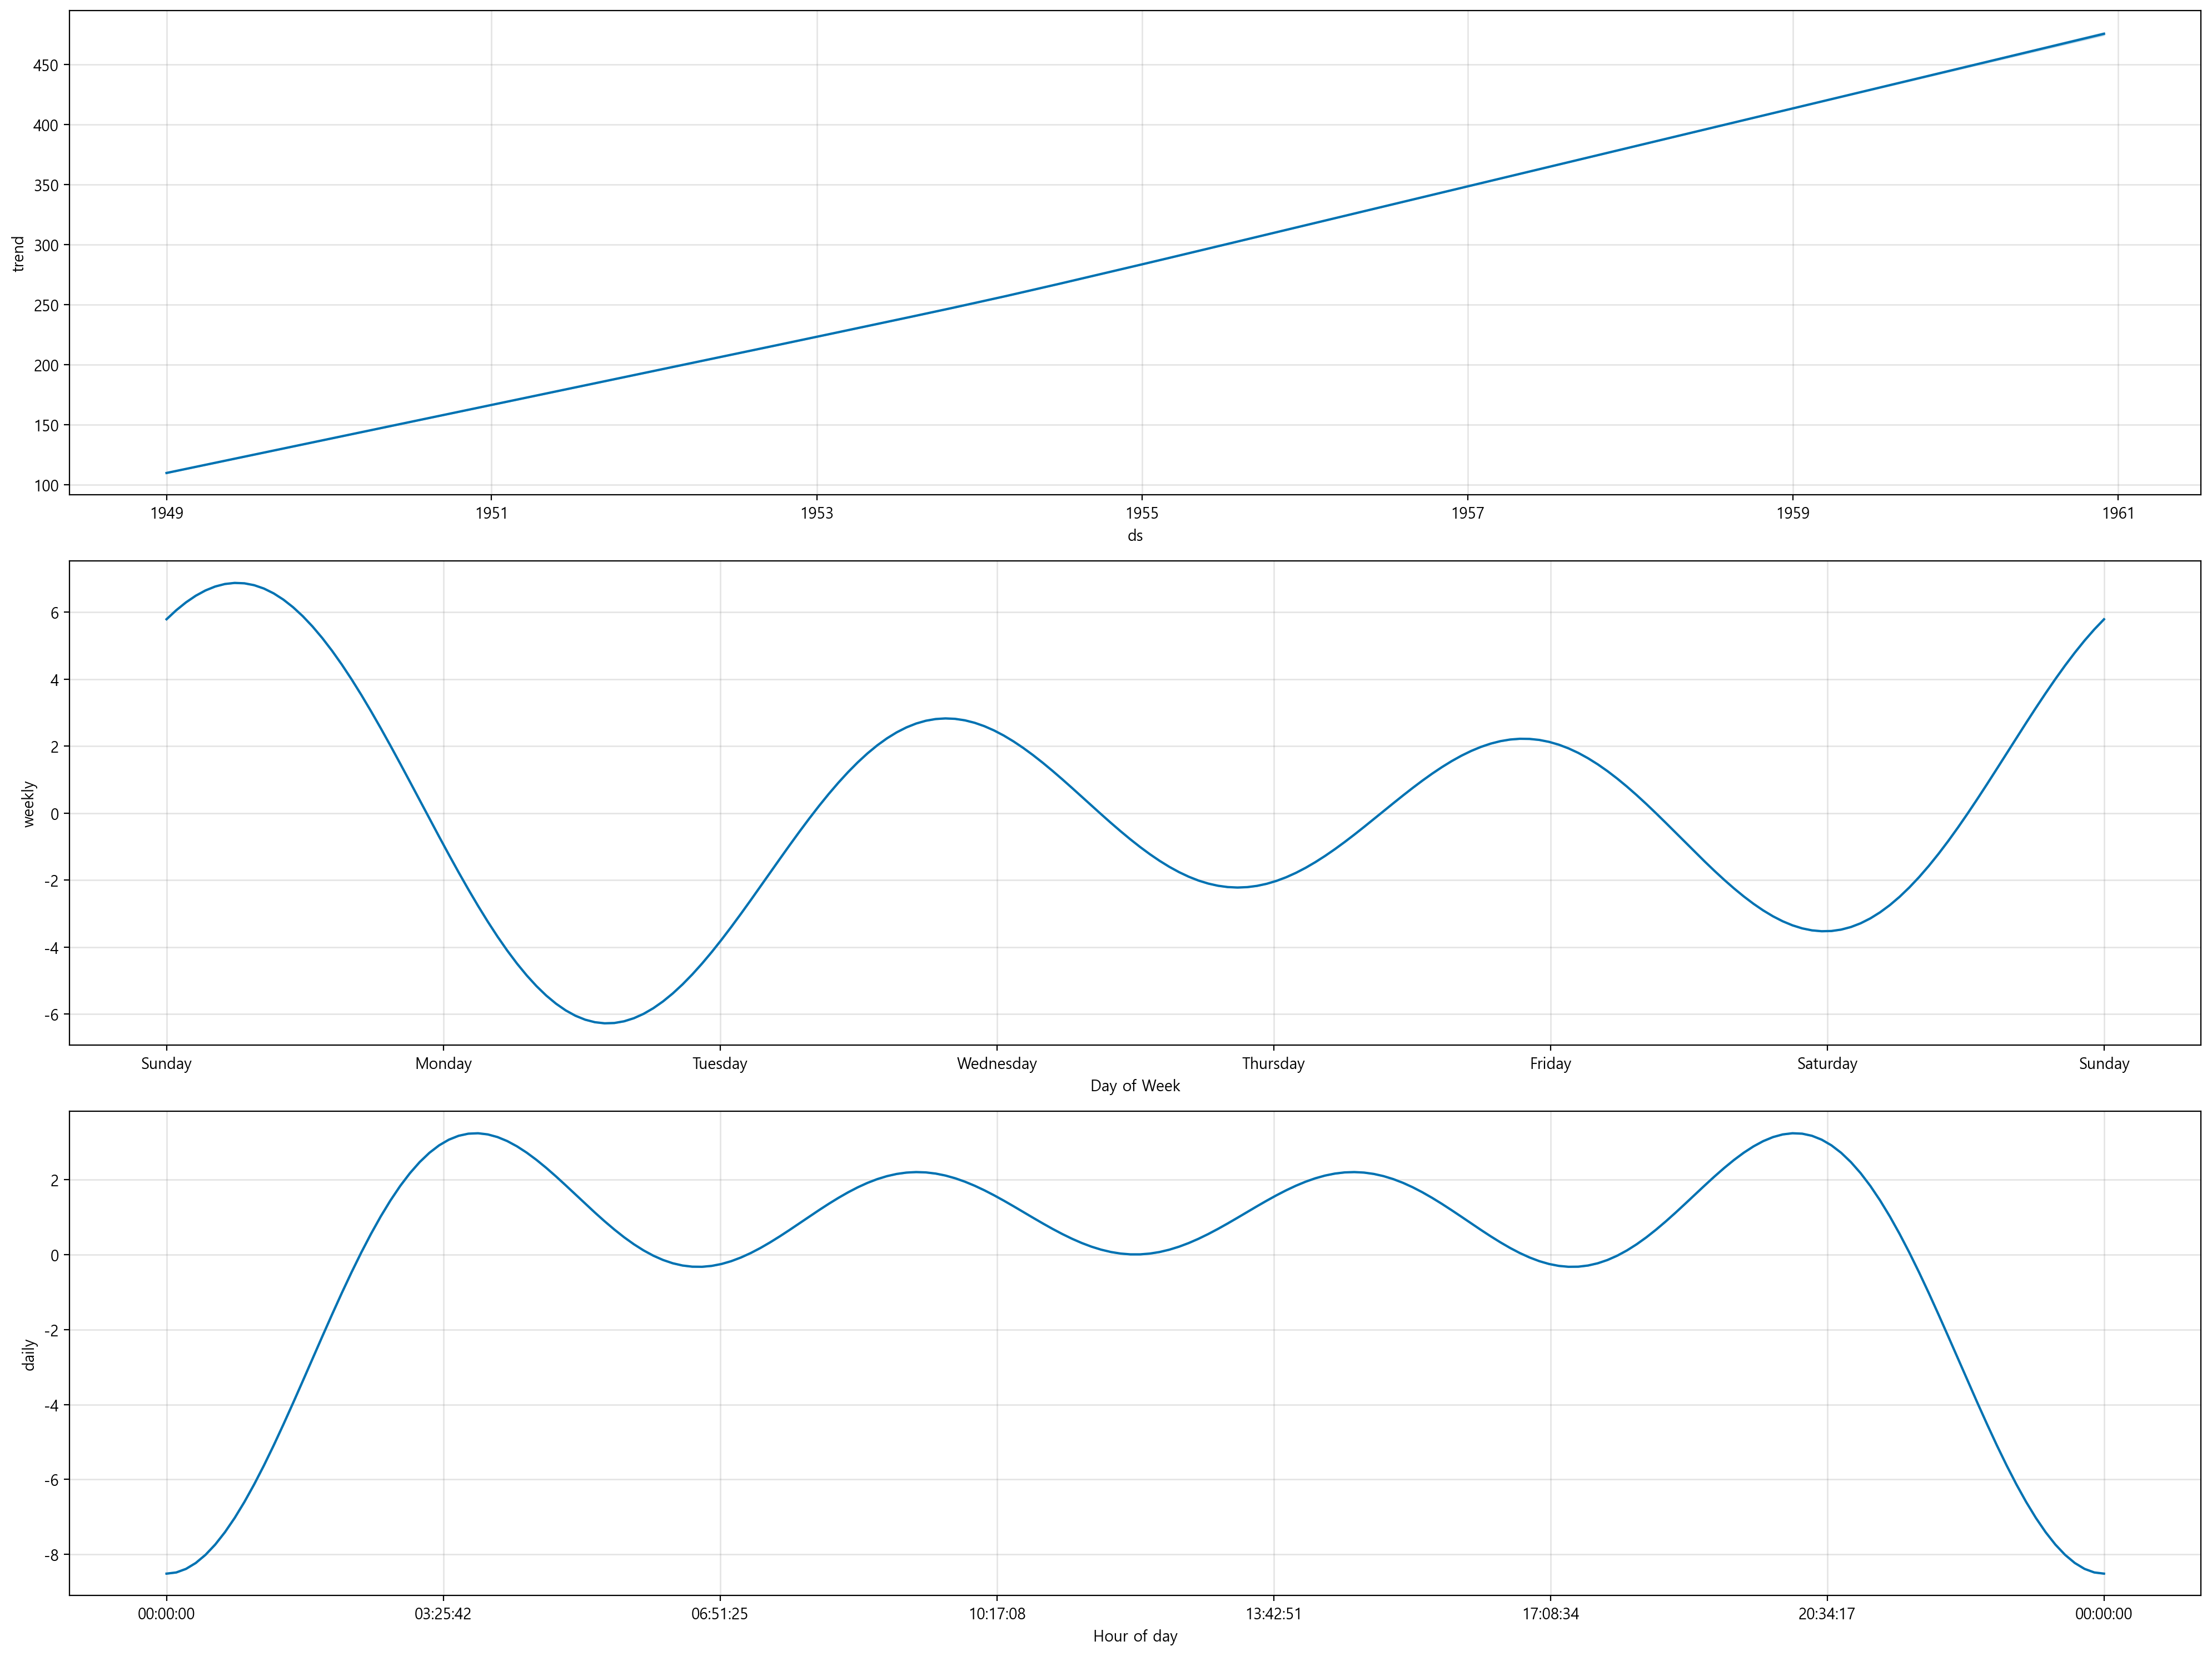

In [11]:
m = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,      # 계절성을 직접 설정하려면 숫자로 지정
    daily_seasonality=True,
    seasonality_prior_scale = 1
)
m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize=(20, 15))
fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()

#### (3) 월단위 계절성 직접 추가

11:23:57 - cmdstanpy - INFO - Chain [1] start processing
11:23:57 - cmdstanpy - INFO - Chain [1] done processing


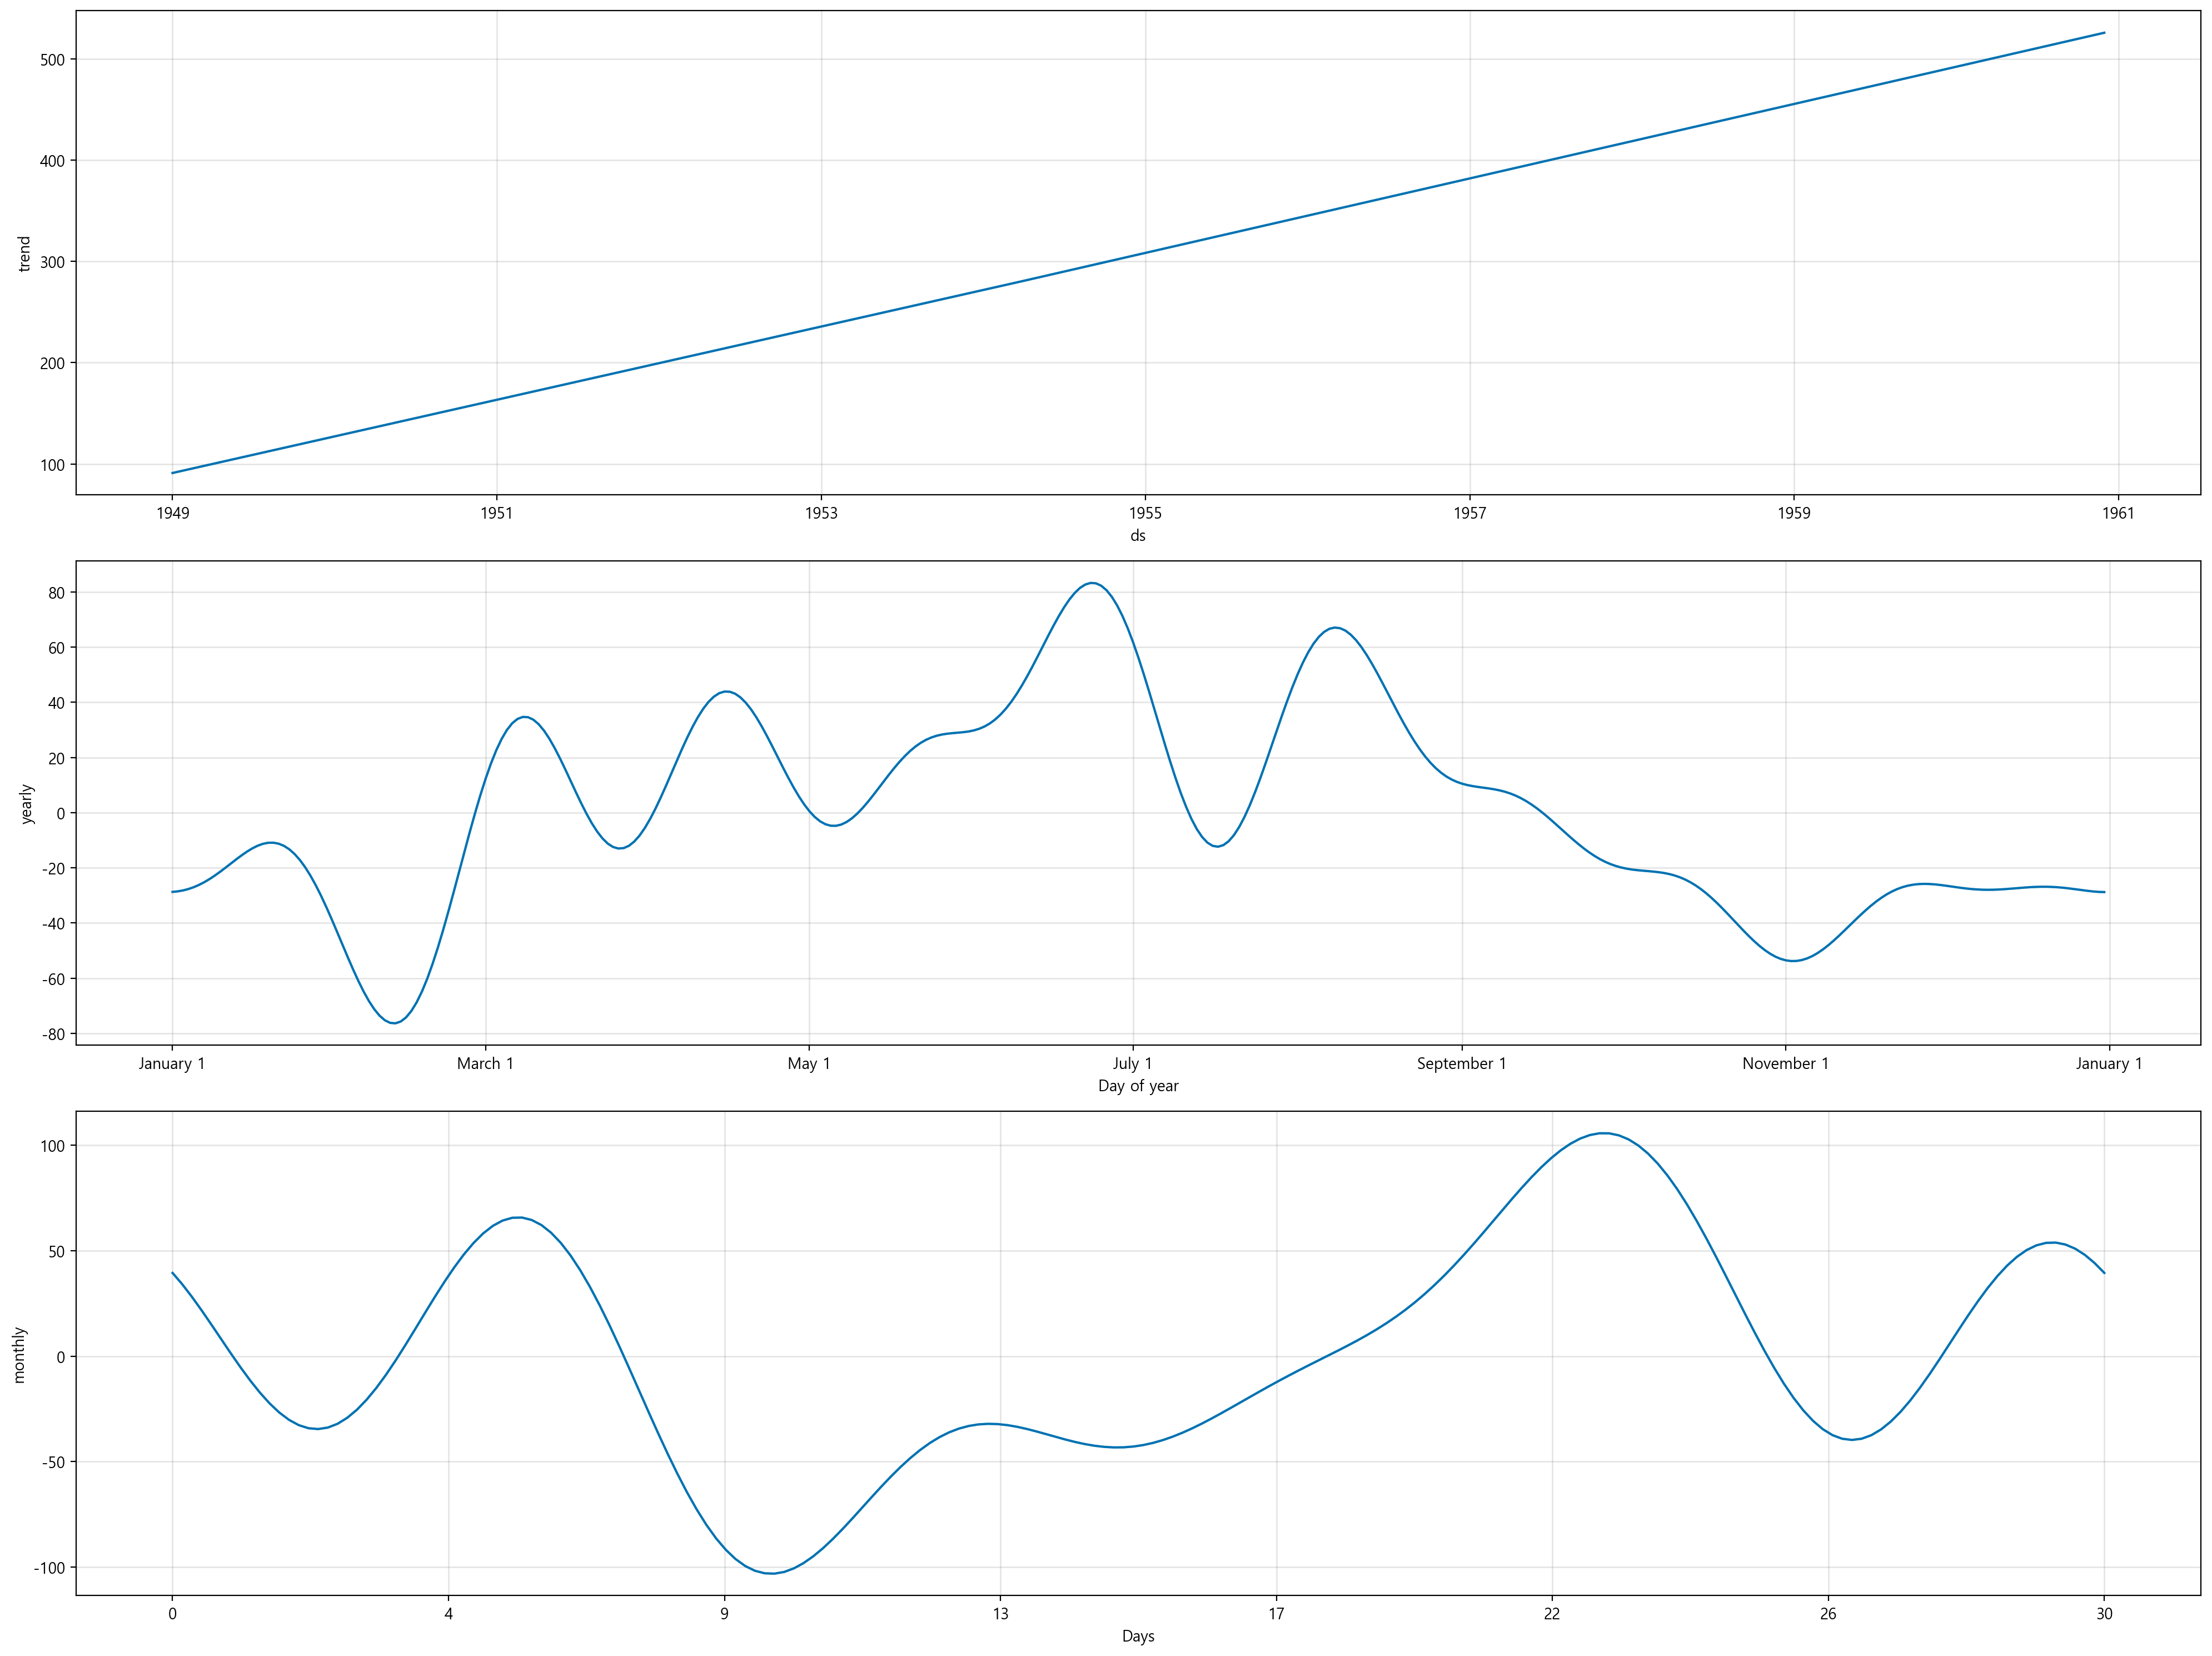

In [12]:
m = Prophet()

# 월단위 계절성 추가
# period -> 데이터에서 1달을 의미하는 간격
# fourier_order -> 푸리에 차수
#      Prophet은 기본적으로 주간 계절성에 대해 3의 푸리에 차수를 사용하고 
#      연간 계절성에 대해 10을 사용하기 때문에 중간 값을 추정해서 적용함
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize=(20, 15))
fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()

> 조건부 계절성 추가도 가능
>
> https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html

### [4] 공휴일 설정

| Parameter	| Description |
|---|---|
| holidays | 휴일 또는 이벤트 기간을 명시한 데이터프레임 |
| holiday_prior_scale | holiday 반영 강도 |

#### (1) 직접 공휴일 데이터프레임 생성

`holiday`, `ds` 두 개의 필드를 갖는 데이터 프레임을 생성해야 한다.

`holiday` 필드에는 모두 `holiday`라는 문자열 값을 설정

`ds`필드에는 날짜값을 설정

##### 기간 데이터 샘플 예시

In [22]:
date_range('2017-05-05', '2017-06-03', freq='D')

DatetimeIndex(['2017-05-05', '2017-05-06', '2017-05-07', '2017-05-08',
               '2017-05-09', '2017-05-10', '2017-05-11', '2017-05-12',
               '2017-05-13', '2017-05-14', '2017-05-15', '2017-05-16',
               '2017-05-17', '2017-05-18', '2017-05-19', '2017-05-20',
               '2017-05-21', '2017-05-22', '2017-05-23', '2017-05-24',
               '2017-05-25', '2017-05-26', '2017-05-27', '2017-05-28',
               '2017-05-29', '2017-05-30', '2017-05-31', '2017-06-01',
               '2017-06-02', '2017-06-03'],
              dtype='datetime64[ns]', freq='D')

In [33]:
holidays = DataFrame({
    'holiday': 'holiday',
    'ds':concat([
        Series(date_range('1949-05-05', '1949-06-03', freq='D')),
        Series(date_range('1950-05-05', '1950-06-03', freq='D')),
        Series(date_range('1951-05-05', '1951-06-03', freq='D')),
        Series(date_range('1952-05-05', '1952-06-03', freq='D')),
        Series(date_range('1953-05-05', '1953-06-03', freq='D')),
        Series(date_range('1954-05-05', '1954-06-03', freq='D')),
        Series(date_range('1955-05-05', '1955-06-03', freq='D')),
        Series(date_range('1956-05-05', '1956-06-03', freq='D')),
        Series(date_range('1957-05-05', '1957-06-03', freq='D')),
        Series(date_range('1958-05-05', '1958-06-03', freq='D')),
        Series(date_range('1959-05-05', '1959-06-03', freq='D')),
        Series(date_range('1960-05-05', '1960-06-03', freq='D'))
    ])
})

my_pretty_table(holidays.head())

+----+-----------+---------------------+
|    | holiday   | ds                  |
|----+-----------+---------------------|
|  0 | holiday   | 1949-05-05 00:00:00 |
|  1 | holiday   | 1949-05-06 00:00:00 |
|  2 | holiday   | 1949-05-07 00:00:00 |
|  3 | holiday   | 1949-05-08 00:00:00 |
|  4 | holiday   | 1949-05-09 00:00:00 |
+----+-----------+---------------------+


13:44:46 - cmdstanpy - INFO - Chain [1] start processing
13:44:46 - cmdstanpy - INFO - Chain [1] done processing


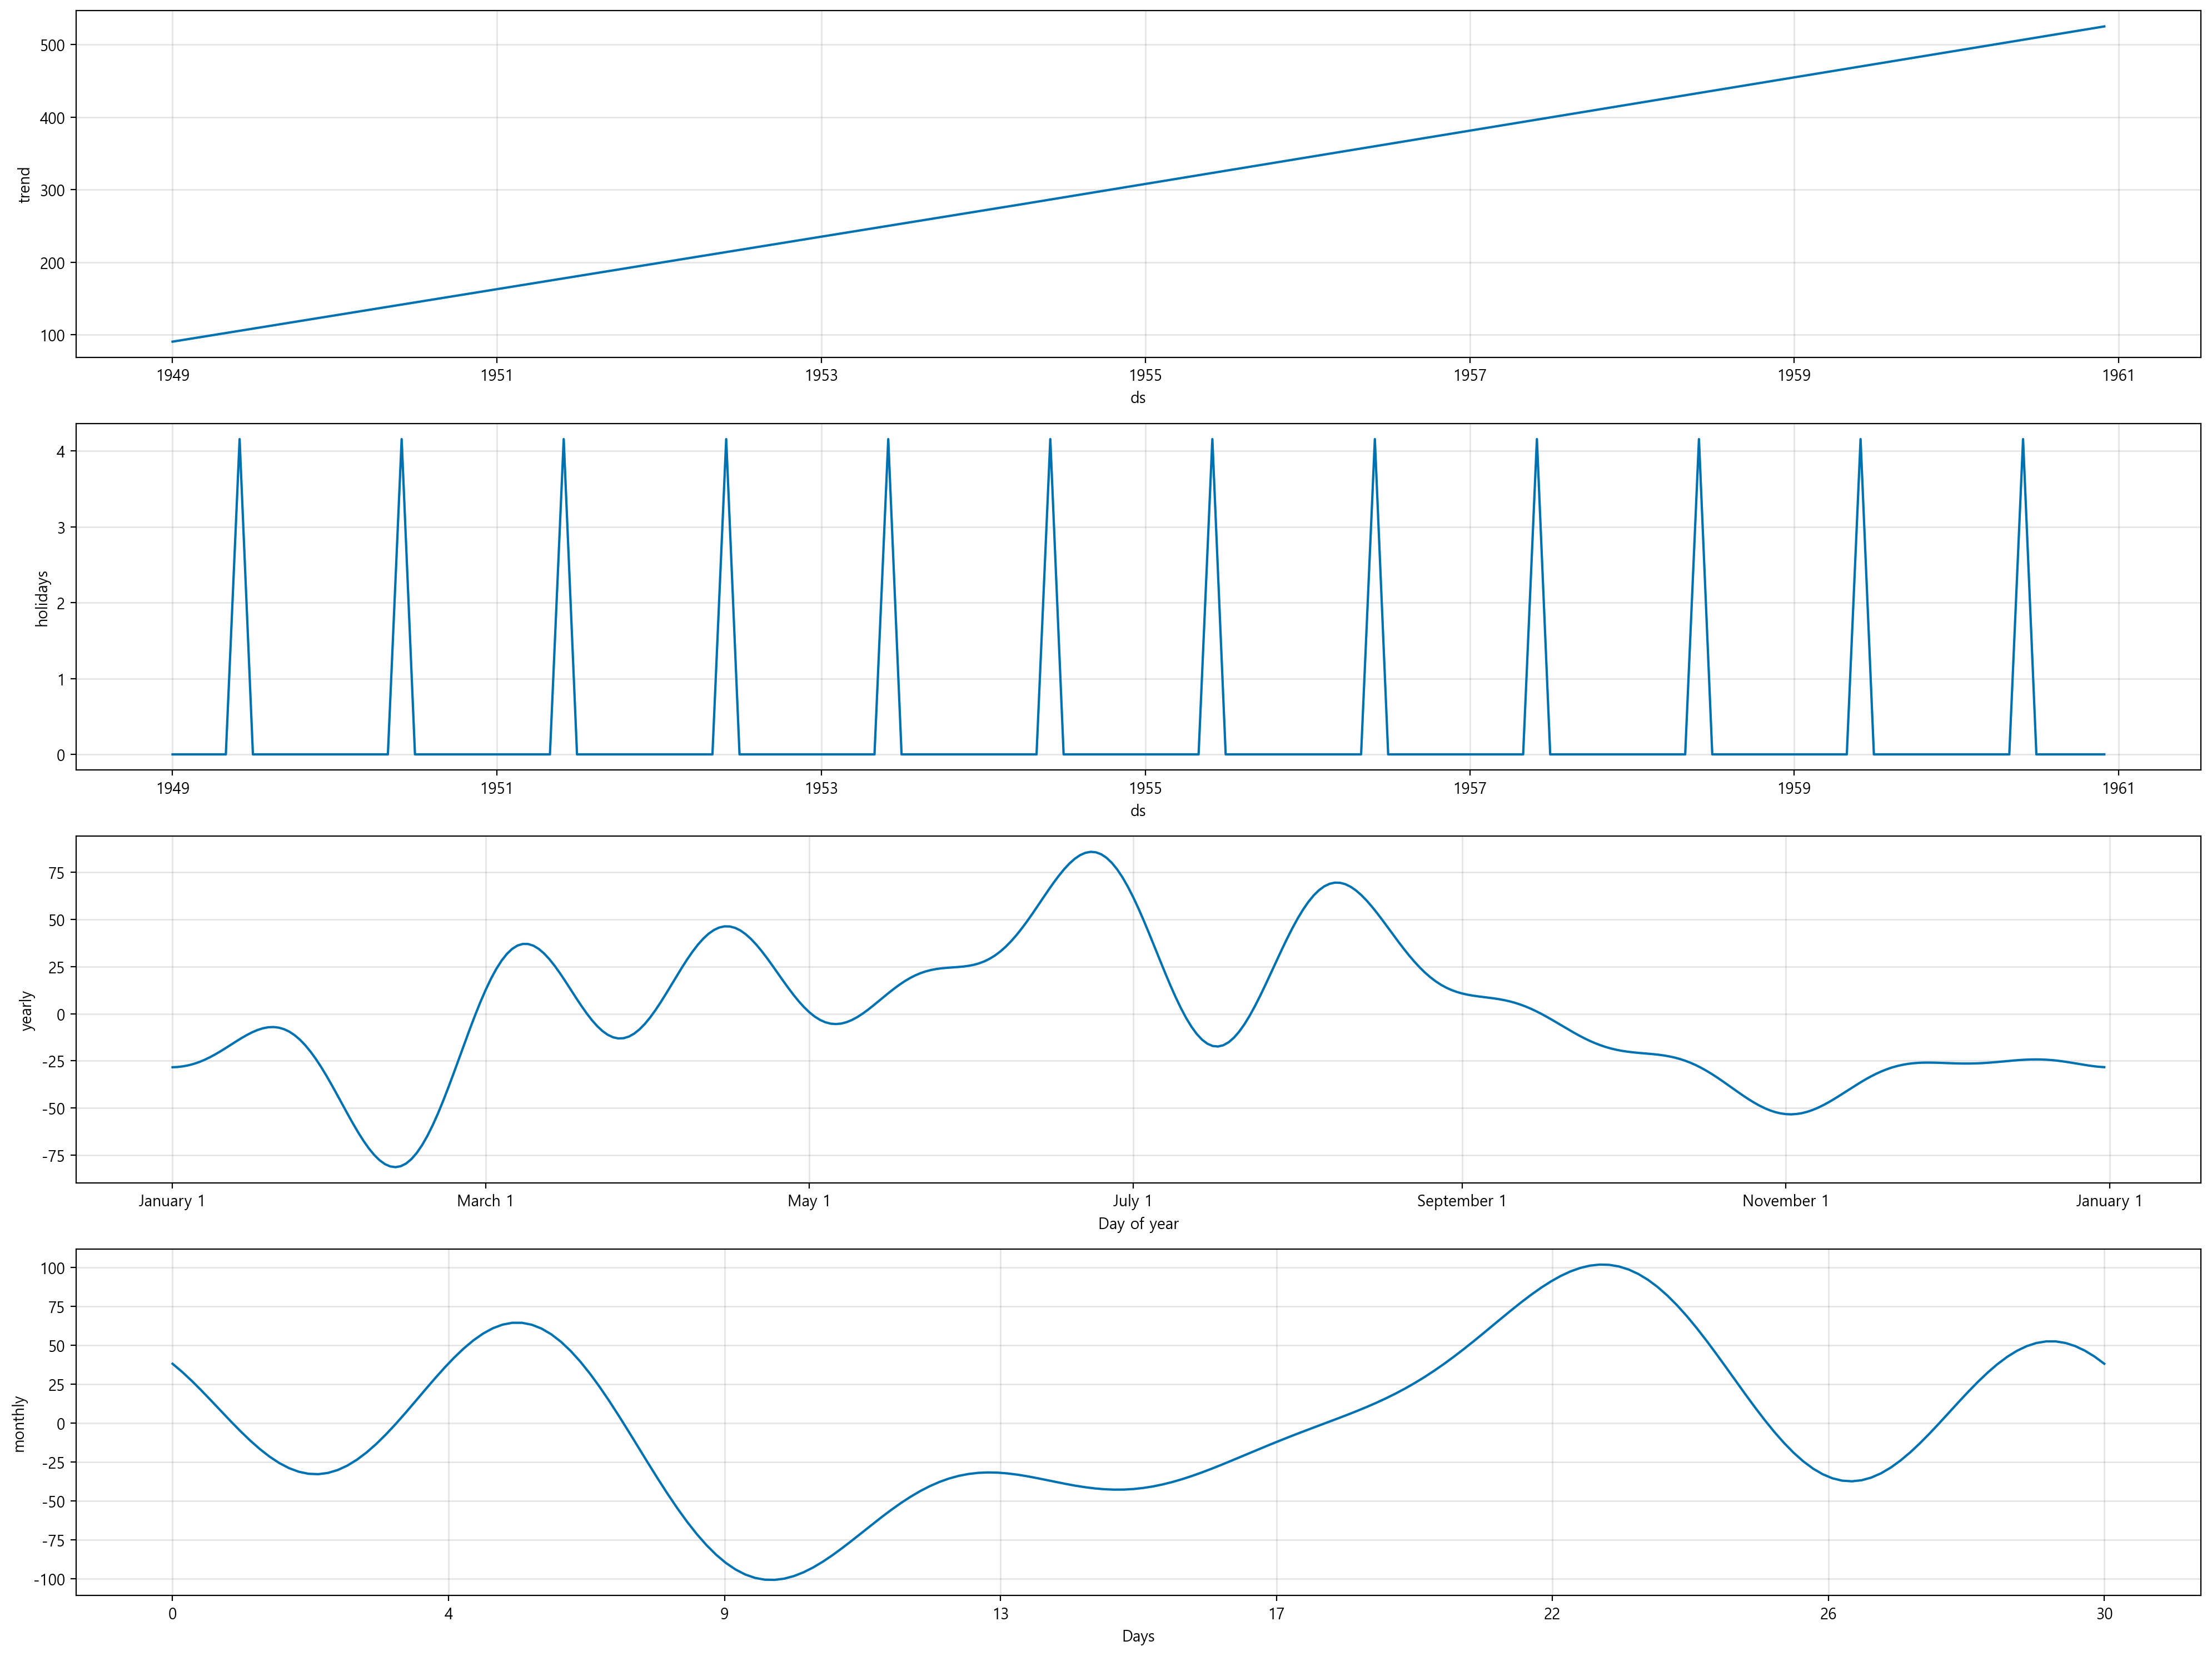

In [34]:
m = Prophet(
    holidays = holidays,
    holidays_prior_scale = 15
)

m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize=(20, 15))
fig.set_dpi(200)
ax = fig.gca()
plt.show()
plt.close()

#### (2) API를 통한 공휴일 데이터 활용

현재 사용가능한 국가 코드 목록

```
Brazil (BR), Indonesia (ID), India (IN), Malaysia (MY), Vietnam (VN), Thailand (TH), Philippines (PH), Pakistan (PK), Bangladesh (BD), Egypt (EG), China (CN), and Russian (RU), Korea (KR), Belarus (BY), and United Arab Emirates (AE)
```

13:48:24 - cmdstanpy - INFO - Chain [1] start processing
13:48:24 - cmdstanpy - INFO - Chain [1] done processing


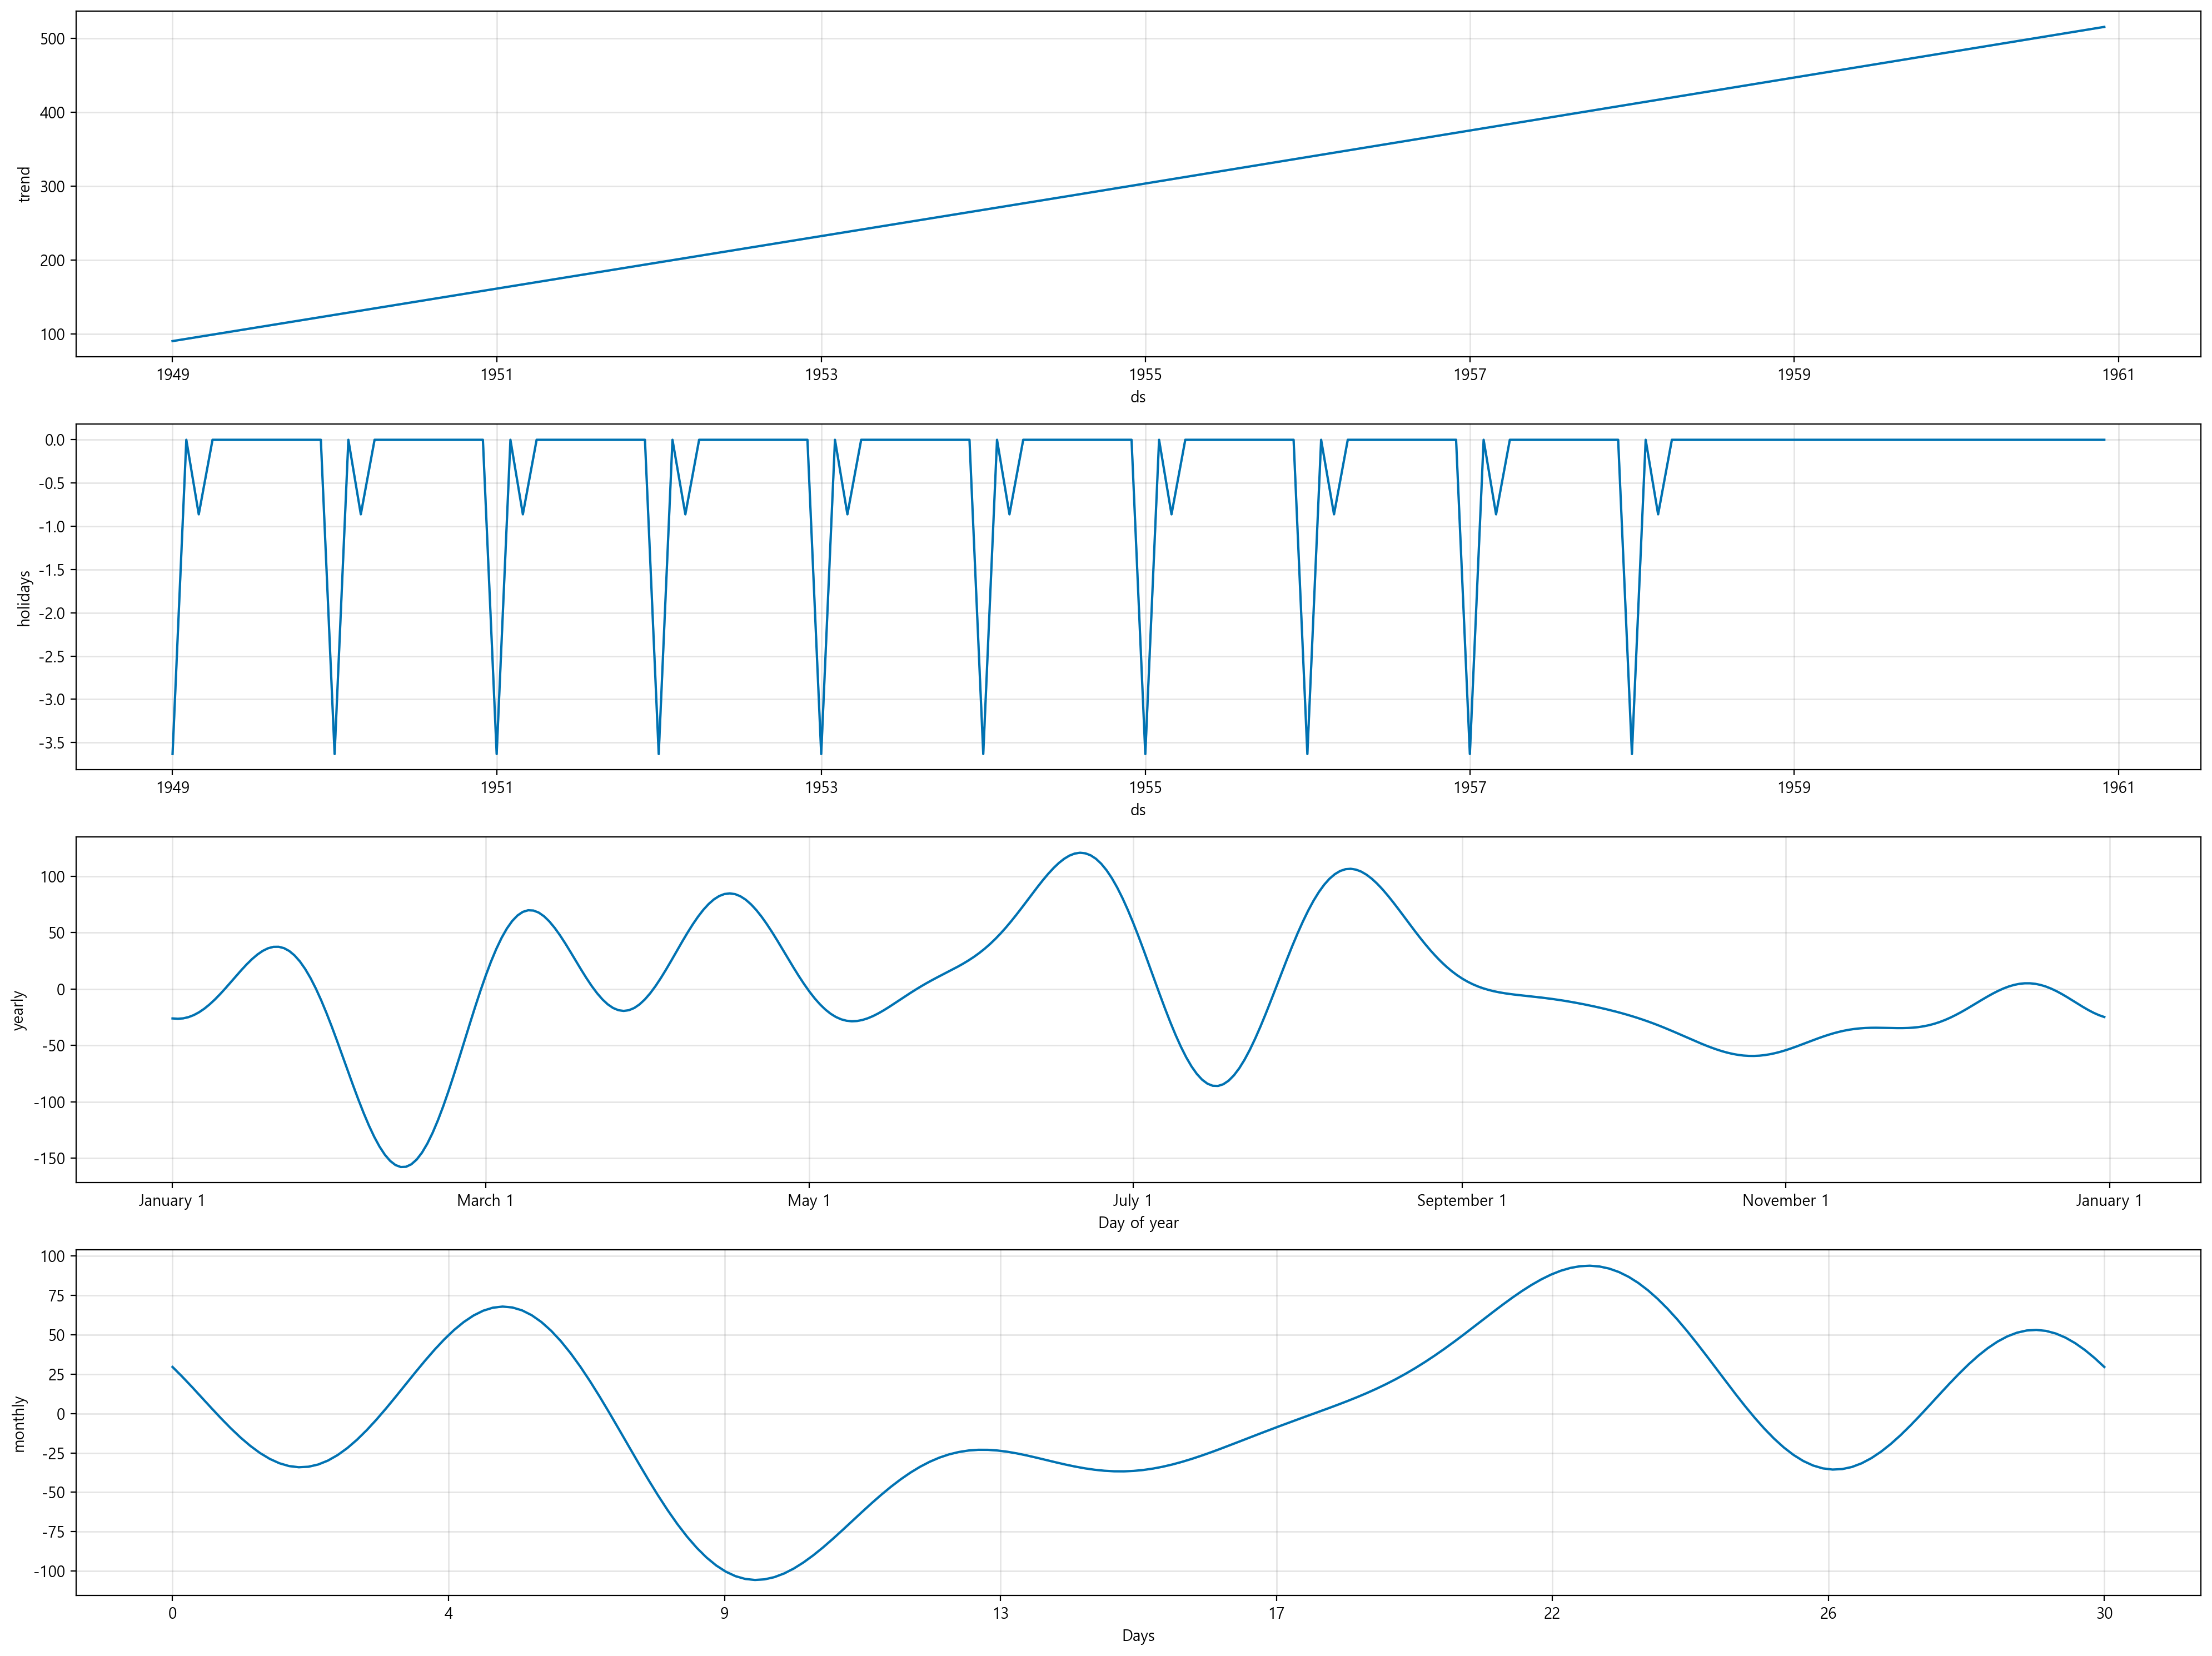

In [36]:
m = Prophet()

m.add_country_holidays(country_name='KR')
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)

m.fit(train)

future = m.make_future_dataframe(periods=len(test), freq='M')
forecast = m.predict(future)

fig = m.plot_components(forecast, figsize=(20, 15))
fig.set_dpi(200)
ax=fig.gca()
plt.show()
plt.close()                      
                                


In [37]:
m.train_holiday_names

0                                        New Year's Day
1                             Independence Movement Day
2                                     Tree Planting Day
3                                      Constitution Day
4                                        Liberation Day
5                                               Chuseok
6                               National Foundation Day
7                                            Hangul Day
8                                    United Nations Day
9                                         Christmas Day
10                                   Local Election Day
11                            Presidential Election Day
12                       National Assembly Election Day
13                                         Memorial Day
14                    President Syngman Rhee's Birthday
15    Anniversary of the 1st National Assembly Election
16                   Baekbeom Kim Ku's Funeral Ceremony
17           Joint Memorial Service for Fallen S